# Project Overview
This project forecasts monthly sales volumes of retail products to support procurement and inventory management decisions. Using historical data, engineered features capturing seasonality and trends, and multiple regression models, the Random Forest achieved an R² of ~0.91 on unseen April 2025 data. Forecasts help prioritize stocking high-demand items and reduce stockouts.

It includes **two phases**:  
1️- Model development and evaluation using historical data.  
2️- Forecasting April 2025 sales and comparing predictions with actual results.

The best model (Random Forest) achieved an R² of ~0.91, providing accurate demand estimates to guide procurement decisions.

In [ ]:
!pip install xgboost scikit-learn matplotlib seaborn
!pip install category_encoders lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

file = "/content/ModelSource.csv"
data = pd.read_csv(file)
data.head()

,Code,Description,Unit_Cost,Unit_Price,Unit_Profit,Amount_Sold,Margin%,Total_Cost,Total_Sale,Total_Profit,Month,Year
0,46131,Beef Burger Bov W/ Friboi Cheese 120G,2.08,4.49,2.41,27.00,42.74,56.08,121.23,65.15,7,2024
1,24513,Avocado In Bulk Kg,5.77,9.15,3.38,223.86,36.95,1291.09,2047.76,756.67,7,2024
2,25049,Pineapple Unit,3.22,4.29,1.07,1098.00,24.81,3540.17,4708.50,1168.33,7,2024
3,72665,Pineapple Offer,2.50,0.99,-1.51,22.00,-152.53,55.00,21.78,-33.22,7,2024
4,68161,Pumpkin Baiana In Bulk Kg,1.42,2.46,1.04,244.12,42.22,346.50,599.74,253.24,7,2024


#1 Phase
In this phase, I developed and evaluated predictive models to estimate monthly product sales volumes (Amount Sold). This target was chosen because accurately forecasting demand is the foundation for most retail decisions, including procurement, inventory management, and revenue planning. Predicting sales volume provides the most direct business value and is typically more stable and explainable than predicting costs or margins, which often depend on external supplier and pricing factors.

Key steps included:

- Preparing historical sales data with time-based and aggregated features to capture seasonality and recent trends.

- Comparing regression models (Linear Regression, Random Forest, SVR) using GridSearchCV.

- Selecting the best model based on R², MAE, and RMSE metrics.

- Analyzing feature importance and visualizing actual vs. predicted results.

This approach created a reliable baseline for forecasting demand and supporting data-driven planning decisions.



In [ ]:
# Preparing the data

# Converting columns to numeric
data['Amount_Sold'] = pd.to_numeric(data['Amount_Sold'], errors='coerce').fillna(0)


# Creating a data set excluding all unecessary features
data_model = data.drop(['Total_Cost', 'Total_Sale', 'Total_Profit', 'Unit_Profit'], axis=1) #These are derived directly from Amount_Sold.
                                                                 # Including them would cause data leakage, which means the model would "cheat" by using
                                                                 # information it wouldn’t have in a real-world prediction scenario.

# Sorting by product and time
data_model = data_model.sort_values(['Code', 'Year', 'Month']) #These are derived directly from Amount_Sold. Including them would cause data leakage,
                                                               # which means the model would "cheat" by using information it wouldn’t have in a real-world
                                                               # prediction scenario.

# Creating lag feature: previous month sales per product and fillin null features
data_model['Prev_Month_Sales'] = data_model.groupby('Code')['Amount_Sold'].shift(1) # For each Code, shift shifts the Amount_Sold down by
                                                               # 1 row, getting the sales from the previous month. This helps the model learn temporal
                                                               # trends. For example, if a product sold well last month, it might sell welle this month too.
                                                               # It's useful for time series forecasting.

# Creating combined time feature
data_model['YearMonth'] = data_model['Year'] * 12 + data_model['Month'] # Converts year and month into a single continuous number:
                                                               # e.g 2024 * 12 + 5 = 24293 (for May 2024). This allows the model to understand progression
                                                               # over time as a numerical value. Useful for capturing trends like growth or decline over months.

# Encoding Month as cyclical features
# We use sin() and cos() to turn months into a circle! This helps the computer understand that December and January are next to each other,
# just like on a calendar. It's like putting months around a clock face: sin() gives the up/down position, and cos() gives the left/right
# position. That way, the model knows time goes around and not just in a straight line!
data_model['Month_sin'] = np.sin(2 * np.pi * data_model['Month'] / 12)
data_model['Month_cos'] = np.cos(2 * np.pi * data_model['Month'] / 12)

# Creating a Date column (for filtering later)
data_model['Date'] = pd.to_datetime(data_model[['Year', 'Month']].assign(DAY=1))

# Adding rolling 12 month sum and mean of Amount_Sold per product

# Calculate rolling 12-month sum and mean sales per product, shifted by 1 month to exclude current month
# 'window=12' defines the 12-month period for the rolling calculation
# 'min_periods=1' allows calculation even if fewer than 12 months of data are available (handles early data)
rolling = data_model.groupby('Code')['Amount_Sold'].rolling(window=12, min_periods=1)
data_model['Last_12M_Sales_Sum'] = rolling.sum().shift(1).reset_index(level=0, drop=True).fillna(0)
data_model['Last_12M_Sales_Mean'] = rolling.mean().shift(1).reset_index(level=0, drop=True).fillna(0)
# rolling.sum(): calculates rolling sum over the window for each product group
# shift(1): excludes current month to prevent data leakage by shifting results down
# reset_index(): aligns rolling results with original DataFrame rows, dropping group index
# fillna(0): replaces NaNs (due to insufficient data at start) with zero

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import category_encoders as ce

# Defining features and targets
features = ['Code', 'Unit_Cost', 'Unit_Price', 'Prev_Month_Sales', 'Month_sin', 'Month_cos', 'YearMonth',
            'Last_12M_Sales_Sum', 'Last_12M_Sales_Mean']
X = data_model[features]
y = data_model['Amount_Sold']

# Train-test split
# We split data into:
# - X_train_val: used for training and cross-validation during model tuning (GridSearchCV)
# - X_holdout: completely unseen data, used once at the end for final unbiased evaluation
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining categorical and numeric columns
cat_cols = ['Code']
num_cols = [col for col in features if col not in cat_cols]

# Defining preprocessing pipelines
# For models that require scaling (SVR, Linear Regression): impute missing + scale
numeric_scaled = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# For tree-based models (Random Forest): only impute missing values (no need to scale)
numeric_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Target encoder for categorical columns (applied in both cases)
categorical = ce.TargetEncoder(cols=cat_cols)

# Column transformers
preprocessor_scaled = ColumnTransformer([
    ('cat', categorical, cat_cols),
    ('num', numeric_scaled, num_cols)
])

preprocessor_tree = ColumnTransformer([
    ('cat', categorical, cat_cols),
    ('num', numeric_tree, num_cols)
])

# Defining Models and their Hyperparameter Grids for GridSearch
model_grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100],
            'max_depth': [None, 10]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [10.0],
            'kernel': ['linear']
        }
    }
}

# Training all Models using GridSearchCV
results = {}
best_models = {}

for name, config in model_grids.items():
    # Select appropriate preprocessing for the model
    if name in ['Linear Regression', 'SVR']:
        preprocessor = preprocessor_scaled
    else:  # Random Forest
        preprocessor = preprocessor_tree

    # Defining pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])

    # Preparing parameter grid with correct prefix
    param_grid = {f'model__{k}': v for k, v in config['params'].items()}

    # Performing grid search with cross-validation
    search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
    search.fit(X_train_val, y_train_val)

    # Saving best model
    best_model = search.best_estimator_
    best_models[name] = best_model

    # Evaluating on holdout set
    y_pred = best_model.predict(X_holdout)
    mae = mean_absolute_error(y_holdout, y_pred)
    rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
    r2 = r2_score(y_holdout, y_pred)

    # Storing results
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Best_Params': search.best_params_
    }

    # Printing performance metrics
    print(f"{name}\nR²: {r2:.4f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")
    print(f"\033[1mBest Params:\033[0m {search.best_params_}")
    print('-' * 60)

# Selected the top three models based on a balance of predictive performance, algorithmic diversity, and interpretability:
# - Random Forest: best overall R² performance, robust to outliers and nonlinearities.
# - SVR: margin-based model that captures nonlinear patterns using kernels.
# - Linear Regression: simple, fast, and interpretable baseline for comparison.
# These were retained in their best-performing configurations to reduce runtime while maintaining strong model variety.

Linear Regression
R²: 0.8319
MAE: 48.97
RMSE: 195.70
Best Params: {}
------------------------------------------------------------
Random Forest
R²: 0.8754
MAE: 37.52
RMSE: 168.49
Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
------------------------------------------------------------
SVR
R²: 0.8526
MAE: 44.57
RMSE: 183.27
Best Params: {'model__C': 10.0, 'model__kernel': 'linear'}
------------------------------------------------------------


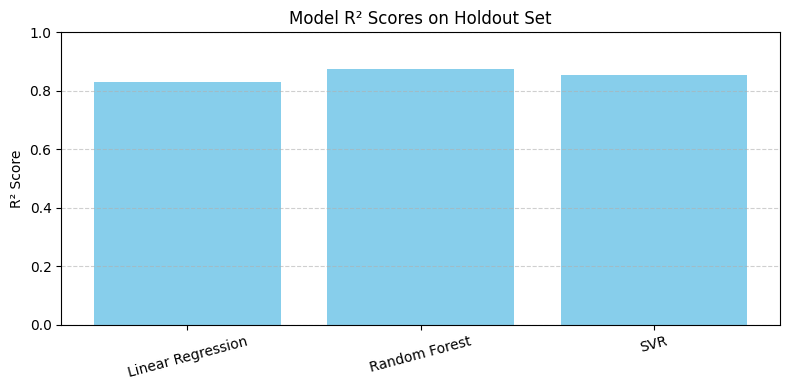

 Best model selected for forecasting: Random Forest


In [ ]:
# Comparing Models

# Plotting R² scores
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), [m['R2'] for m in results.values()], color='skyblue')
plt.title('Model R² Scores on Holdout Set')
plt.ylabel('R² Score')
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Using Best Model to Forecast April 2025
best_model_name = max(results, key=lambda k: results[k]['R2']) # Select the model name with the highest R² score
best_model = best_models[best_model_name]
print(f" Best model selected for forecasting: {best_model_name}")

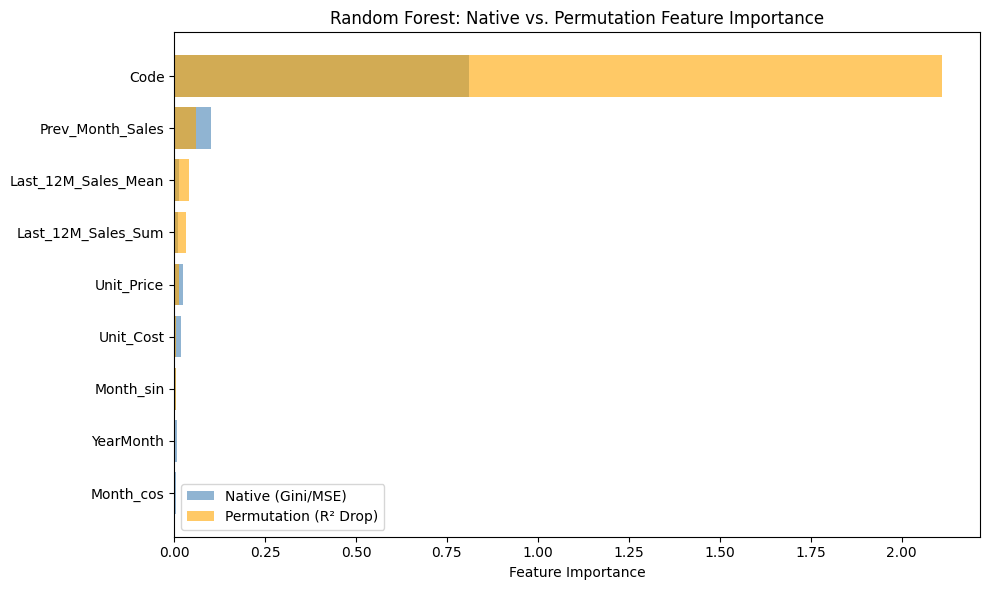

,Feature,Importance_Native,Importance_Permutation
0,Month_cos,0.004458,0.001685
2,YearMonth,0.006898,0.003615
1,Month_sin,0.006485,0.004137
5,Unit_Cost,0.019649,0.005513
6,Unit_Price,0.024067,0.012600
3,Last_12M_Sales_Sum,0.011838,0.032546
4,Last_12M_Sales_Mean,0.013685,0.040869
7,Prev_Month_Sales,0.101772,0.060610
8,Code,0.811149,2.110091


In [ ]:
# Defining feature importance for the preditions based on
from sklearn.inspection import permutation_importance

# Getting the best model
rf_model = best_models['Random Forest']

# Extracting the trained Random Forest model from the pipeline to access native feature importance
rf_estimator = rf_model.named_steps['model']

# Native feature importance (Gini importance)
native_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance_Native': rf_estimator.feature_importances_
}).sort_values(by='Importance_Native', ascending=True)

# Permutation importance (on the full pipeline)
perm_result = permutation_importance(
    rf_model,  # pipeline with preprocessing + model
    X_holdout,
    y_holdout,
    n_repeats=10,
    random_state=42,
    scoring='r2'
)

perm_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance_Permutation': perm_result.importances_mean
}).sort_values(by='Importance_Permutation', ascending=True)

# Merge both importance metrics on Feature
merged_df = pd.merge(
    native_importance_df,
    perm_importance_df,
    on='Feature'
).sort_values(by='Importance_Permutation', ascending=True)

# Plot side-by-side horizontal bars for comparison
plt.figure(figsize=(10, 6))
plt.barh(merged_df['Feature'], merged_df['Importance_Native'], alpha=0.6, label='Native (Gini/MSE)', color='steelblue')
plt.barh(merged_df['Feature'], merged_df['Importance_Permutation'], alpha=0.6, label='Permutation (R² Drop)', color='orange')
plt.xlabel("Feature Importance")
plt.title("Random Forest: Native vs. Permutation Feature Importance")
plt.legend()
plt.tight_layout()
plt.show()

merged_df

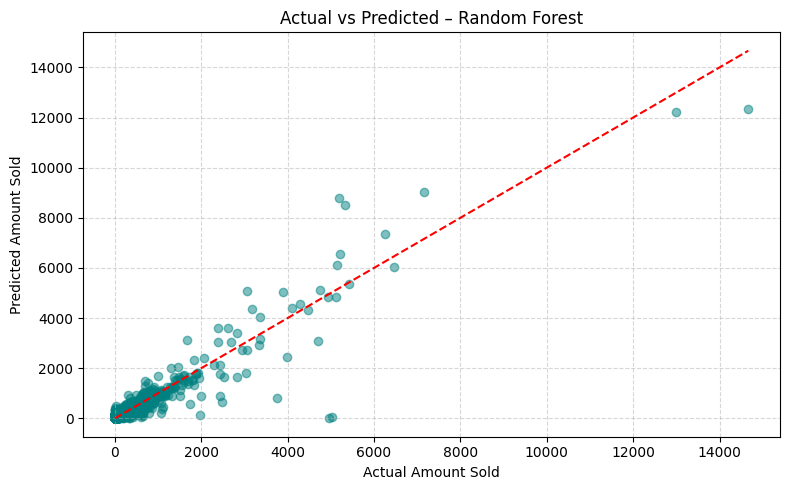

In [ ]:
# Comparing Actual vs Predicted (Best Model)

# Predict again (to be sure we're using the correct model)
y_pred = best_model.predict(X_holdout)

# Plotting actual vs predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_holdout, y_pred, alpha=0.5, color='teal')
plt.plot([y_holdout.min(), y_holdout.max()], [y_holdout.min(), y_holdout.max()], 'r--')
plt.xlabel('Actual Amount Sold')
plt.ylabel('Predicted Amount Sold')
plt.title(f'Actual vs Predicted – {best_model_name}')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

 # 2 Phase

We will focus on forecasting product sales volumes for April 2025, using the last 12 months of data. This phase involves:

- Time-based filtering

- Feature engineering

- Hyperparameter tuning (GridSearch)

- Final model evaluation and comparison to actual data

By building a reliable predictive model, we aim to generate accurate forecasts of product demand. Unit costs and margins are assumed to remain constant at their most recently observed values to ensure realistic revenue and profit estimates without introducing unnecessary prediction uncertainty. This approach supports better planning, inventory optimization, and data-driven decision-making in upcoming retail cycles.


Top 20 Predicted Products for April 2025:


,Code,Description,Unit_Price,Predicted_Amount_Sold
277,24556,Chicken Cold Kg,10.06,8831.7411
100,6282,Milk L Life Compleite Integral 1L,4.72,7243.9709
251,24518,Banana Nanica In Bulk Kg,3.57,6671.0377
265,24539,Tomato In Bulk Kg,8.10,6019.5220
248,24514,Potato In Bulk Kg,3.14,5456.7377
253,24520,Onion In Bulk Kg,3.07,5233.2980
319,24668,French Bread Kg,14.81,4890.4401
257,24528,Watermelon In Bulk Kg,2.98,4533.3470
293,24586,Silver Banana In Bulk Kg,7.58,3913.9902
574,40992,Super Chicken Chicken Steak 100G,2.06,3540.1970


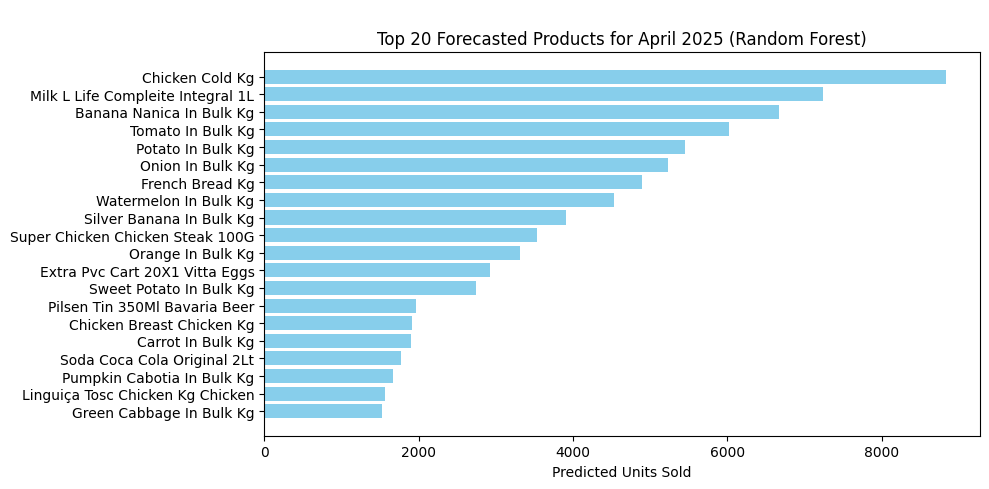

In [ ]:
# Preparing the target data, prediciting and displaying it

# Filtering March 2025 data (to create April 2025 features) and preparing April 2025 base
april_pred = data_model[data_model['Date'] == '2025-03-01'].copy()
april_pred['Month'] = 4
april_pred['Year'] = 2025
april_pred['Date'] = pd.to_datetime({'year': april_pred['Year'], 'month': april_pred['Month'], 'day': 1})
april_pred['YearMonth'] = april_pred['Year'] * 12 + april_pred['Month']
april_pred['Month_sin'] = np.sin(2 * np.pi * april_pred['Month'] / 12)
april_pred['Month_cos'] = np.cos(2 * np.pi * april_pred['Month'] / 12)
april_pred['Prev_Month_Sales'] = april_pred['Amount_Sold']

# Removing any existing aggregated columns to avoid _x/_y suffix issues
april_pred = april_pred.drop(columns=['Last_12M_Sales_Sum', 'Last_12M_Sales_Mean'])

# Calculating sum and mean of Amount_Sold for each product over last 12 months
agg_sales = data_model.groupby('Code')['Amount_Sold'].agg(['sum', 'mean']).reset_index()

# Renaming aggregated columns to meaningful names
agg_sales.rename(columns={'sum': 'Last_12M_Sales_Sum', 'mean': 'Last_12M_Sales_Mean'}, inplace=True)

# Merging aggregated data into april_pred by product Code
april_pred = april_pred.merge(agg_sales, on='Code', how='left')

# Preparing feature set
X_test = april_pred[features]

# Predicting
y_test_pred = best_model.predict(X_test)
april_pred['Predicted_Amount_Sold'] = y_test_pred

# Showing top 10 predictions
top_preds = april_pred.sort_values('Predicted_Amount_Sold', ascending=False).head(20)
print("\nTop 20 Predicted Products for April 2025:")
display(top_preds[['Code', 'Description', 'Unit_Price', 'Predicted_Amount_Sold']])

# Plotting
plt.figure(figsize=(10, 5))
plt.barh(top_preds['Description'], top_preds['Predicted_Amount_Sold'], color='skyblue')
plt.xlabel('Predicted Units Sold')
plt.title(f'\nTop 20 Forecasted Products for April 2025 ({best_model_name})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Adding and excluding features in order to get a set like the original

# Selecting relevant columns
cleaned_df = april_pred[['Code', 'Description', 'Month', 'Year', 'Unit_Cost', 'Predicted_Amount_Sold', 'Margin%']].copy()

# Recreate business metrics
cleaned_df['Unit_Price'] = cleaned_df['Unit_Cost'] / (1 - cleaned_df['Margin%'] / 100)
cleaned_df['Unit_Profit'] = cleaned_df['Unit_Price'] - cleaned_df['Unit_Cost']
cleaned_df['Total_Cost'] = cleaned_df['Unit_Cost'] * cleaned_df['Predicted_Amount_Sold']
cleaned_df['Total_Sale'] = cleaned_df['Unit_Price'] * cleaned_df['Predicted_Amount_Sold']
cleaned_df['Total_Profit'] = cleaned_df['Total_Sale'] - cleaned_df['Total_Cost']

# Round financial metrics
cols_to_round = ['Unit_Price', 'Unit_Profit', 'Total_Cost', 'Total_Sale', 'Total_Profit', 'Unit_Cost', 'Predicted_Amount_Sold', 'Margin%']
cleaned_df[cols_to_round] = cleaned_df[cols_to_round].round(2)

# Sorting features
cleaned_df = cleaned_df[[
    'Code', 'Description', 'Unit_Cost', 'Unit_Price', 'Unit_Profit',
    'Predicted_Amount_Sold', 'Margin%', 'Total_Cost', 'Total_Sale',
    'Total_Profit', 'Month', 'Year'
]]

In [ ]:
# Comparing the actual values and the predicted ones
file = "/content/ModelSourceApril2025.csv"
actual_april = pd.read_csv(file)
actual_april.head()

,Code,Description,Unit_Cost,Unit_Price,Unit_Profit,Amount_Sold,Margin%,Total_Cost,Total_Sale,Total_Profit,Month,Year
0,24513,Avocado In Bulk Kg,5.17,8.63,3.46,338.64,40.02,1751.96,2920.93,1168.97,4,2025
1,25049,Pineapple Unit,3.90,5.61,1.71,685.00,30.52,2671.30,3844.48,1173.18,4,2025
2,72665,Pineapple Offer,3.88,2.22,-1.66,40.00,-74.55,155.00,88.80,-66.20,4,2025
3,24541,Pumpkin Cabotia In Bulk Kg,1.37,2.01,0.64,1250.99,31.87,1712.10,2513.10,801.00,4,2025
4,63614,Pumpkin Cabotia Packed Kg,1.37,2.77,1.40,600.84,50.60,823.05,1666.24,843.19,4,2025


Amount Sold
MAE: 40.70
R² Score: 0.9080



,Description_Predicted,Predicted_Amount_Sold,Amount_Sold,Unit_Cost_Actual,Margin%_Actual,Total_Sale_Predicted,Total_Sale_Actual,Total_Profit_Predicted,Total_Profit_Actual
0,Coriander Folhage,1281.44,1524.0,4.00,38.46,8330.53,9905.80,3204.75,3809.80
1,Chicoria Foliage,27.23,29.0,2.00,42.86,95.83,101.50,41.36,43.50
2,Vegetable Foliage,102.64,125.0,2.00,42.86,359.27,437.50,153.98,187.50
3,Rabanese Foliage,17.28,31.0,2.50,44.44,77.77,139.50,34.56,62.00
4,Rule Foliage,145.35,135.0,2.50,44.44,654.13,607.44,290.76,269.94
5,Nugget Black Folder 36G,16.78,8.0,6.15,44.19,184.75,119.92,82.25,70.73
6,Nugget Brown Folder 36G,3.50,3.0,7.00,42.15,42.39,44.97,17.87,23.96
7,100Ml Traditional Peroba Oil,6.16,5.0,5.44,42.79,54.38,59.95,23.31,32.75
8,Creoline 50Ml,2.20,2.0,9.85,27.59,29.99,29.98,8.27,10.28
9,Detergent Clean Crystal 500Ml,154.24,105.0,1.30,40.80,338.94,313.95,147.67,177.36


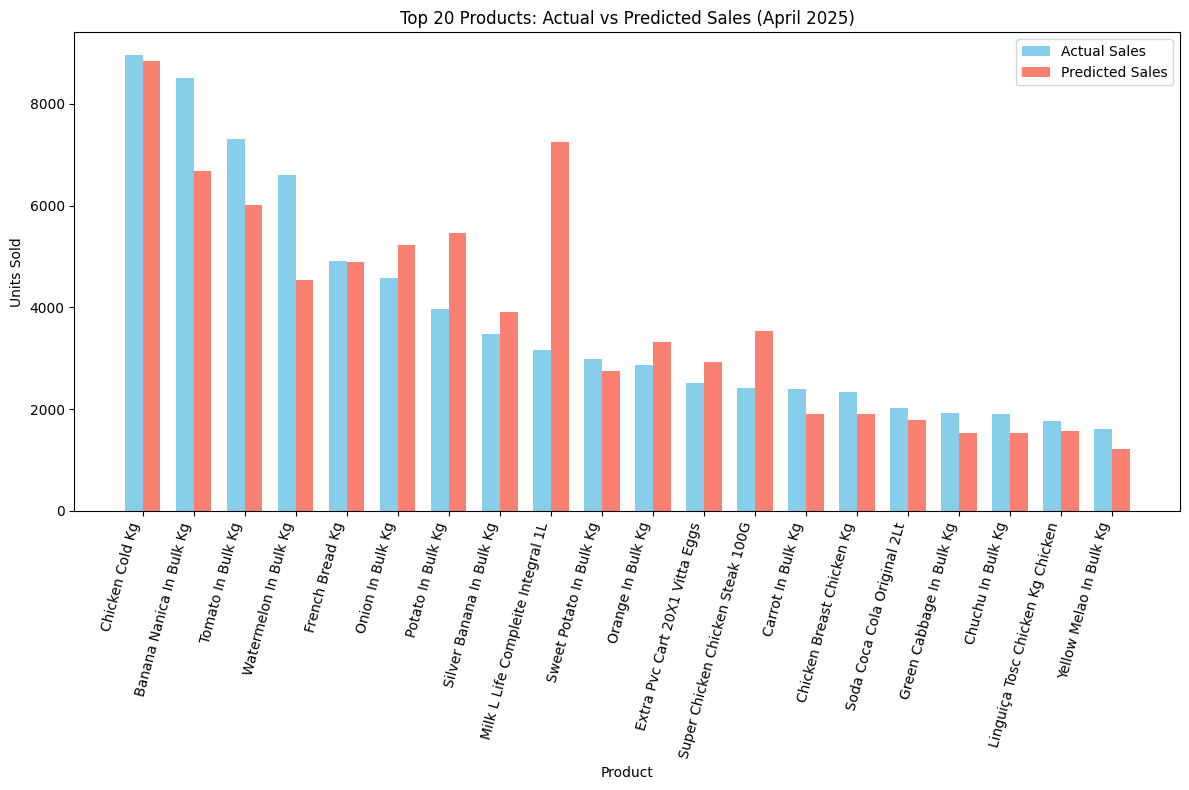

In [ ]:
# Comparing the actual values and the predicted ones

# Merging predicted and actual April 2025 data
comparison_df = cleaned_df.merge(
    actual_april,
    on="Code",
    suffixes=("_Predicted", "_Actual")
)

# Evaluating predicted value
mae = mean_absolute_error(comparison_df["Amount_Sold"], comparison_df["Predicted_Amount_Sold"])
r2 = r2_score(comparison_df["Amount_Sold"], comparison_df["Predicted_Amount_Sold"])

print(f"\033[1mAmount Sold\033[0m")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}\n")

# Showing a sample of side-by-side comparison
display(
    comparison_df[
        [
            "Description_Predicted",
            "Predicted_Amount_Sold",
            "Amount_Sold",
            "Unit_Cost_Actual",
            "Margin%_Actual",
            "Total_Sale_Predicted",
            "Total_Sale_Actual",
            "Total_Profit_Predicted",
            "Total_Profit_Actual"
        ]
    ].head(10)
)

# Plotting the Top 20 Best-Selling Products (Actual vs Predicted Sales)
top_sales_df = comparison_df.sort_values(
    "Amount_Sold",
    ascending=False
).head(20)

plt.figure(figsize=(12, 8))
bar_width = 0.35
indices = np.arange(len(top_sales_df))

plt.bar(
    indices, top_sales_df["Amount_Sold"], bar_width,
    label="Actual Sales", color="skyblue"
)

plt.bar(
    indices + bar_width,
    top_sales_df["Predicted_Amount_Sold"], bar_width,
    label="Predicted Sales", color="salmon"
)

plt.xticks(
    indices + bar_width / 2, top_sales_df["Description_Predicted"],
    rotation=75, ha="right"
)

plt.xlabel("Product")
plt.ylabel("Units Sold")
plt.title("Top 20 Products: Actual vs Predicted Sales (April 2025)")
plt.legend()
plt.tight_layout()
plt.show()

# Business Recommendations
- Focus procurement on the top 20 forecasted products, as they represent ~60% of projected sales volume.
- Monitor actual sales vs. predictions monthly to recalibrate the model.
- Consider price sensitivity: higher unit prices correlate with lower sales for some categories.
- Develop targeted promotions for products with consistently lower forecasted demand.
